In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import statsmodels.api as sm
import multiprocessing as mp
import matplotlib.pyplot as plt
from __future__ import division
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

/Users/jenchieh/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


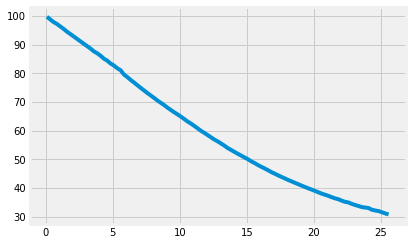

In [2]:
STRIPS = pd.read_excel('./HW1_data.xls')
STRIPS.columns = ['Mat', 'Px']
plt.plot(STRIPS.Mat, STRIPS.Px)

In [3]:
def spot_rate(t, P, APR=True):
    
    r = (100 / P) ** (1 / t) - 1
    if APR: #else: EAR
        r = 2 * ((1 + r) ** 0.5 - 1)
    return r

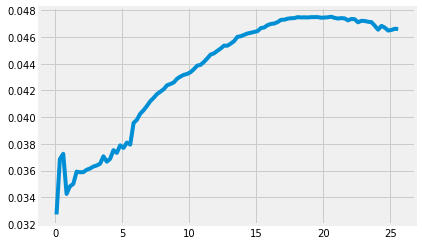

In [4]:
STRIPS.Spot = spot_rate(STRIPS.Mat, STRIPS.Px)
plt.plot(STRIPS.Mat, STRIPS.Spot)

In [5]:
def par_yield(T, DF):
    
    # semiannually compounded  
    t = np.linspace(0.5, T, int(2*T))
    
    return 2 * (1 - DF(T)) / np.sum(DF(t))

def fw_rate(t, dt, DF):
    
    return ((DF(t) / DF(t + dt)) - 1 ) * (1/dt)

## Polynomial YC

In [6]:
lnZ = np.log(STRIPS.Px / 100)
X = pd.concat([STRIPS.Mat**i for i in range(1,6)], axis=1)
X.columns = ['pwr_' + str(i) for i in range(1,6)]

model = sm.OLS(lnZ, X)
poly_res = model.fit()
poly_res.params

pwr_1   -3.261156e-02
pwr_2   -1.077892e-03
pwr_3   -1.988299e-05
pwr_4    2.853257e-06
pwr_5   -4.781605e-08
dtype: float64

## spot rate / par rate / 6mth fw rate

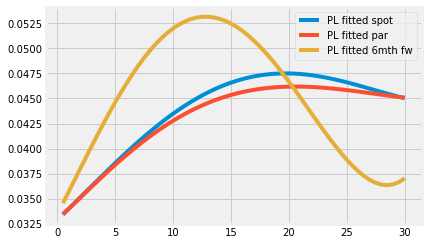

In [7]:
p = np.polynomial.Polynomial(np.r_[0, poly_res.params.values])
poly_Z = lambda t: np.exp(p(t))

ts = np.linspace(0.5, 30, 60)
fitted_spot = spot_rate(ts, poly_Z(ts)*100)
fitted_par = [par_yield(t_i, poly_Z) for t_i in ts]
fitted_fw = [fw_rate(t_i, 0.5, poly_Z) for t_i in ts]

plt.plot(ts, fitted_spot, label='PL fitted spot')
plt.plot(ts, fitted_par, label='PL fitted par')
plt.plot(ts, fitted_fw, label='PL fitted 6mth fw')

plt.legend()

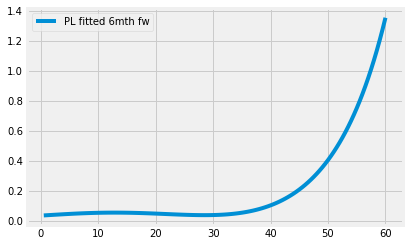

In [8]:
ts = np.linspace(0.5, 60, 120)
fitted_fw = [fw_rate(t_i, 0.5, poly_Z) for t_i in ts]
plt.plot(ts, fitted_fw, label='PL fitted 6mth fw')

plt.legend()

# Multiprocessing

In [9]:
def optimizer(fitted_err, mp_output, m, n):

    print 'Starting:', mp.current_process().name
    np.random.seed()
    p0 = np.hstack([np.random.uniform(0.01, 0.1, n), np.random.uniform(0.01, 15, m)])
    min_obj = lambda p: fitted_err(STRIPS.Mat, STRIPS.Px, p)
    res = opt.minimize(min_obj, p0)
    mp_output.put((res.x, min_obj(res.x)))
    print 'Exiting:', mp.current_process().name
    
def fetch_min_param(res):
    return zip(*res)[0][np.argmin(zip(*res)[1])]

# Nelson-Siegel Model

In [10]:
def Nelson_Siegel_DF(t, params):
    
    b0, b1, b2 = params[0], params[1], params[2]
    t_1, t_2 = t / params[3], t / params[4]
    r = b0 + b1 * (1 - np.exp(-t_1)) / t_1 + b2 * ((1 - np.exp(-t_2)) / t_2 - np.exp(-t_2))
    
    return np.exp(-r * t)

def NS_fitted_err(Mat, Px, params):
    
    err = Px - Nelson_Siegel_DF(Mat, params) * 100
    w = 1 / Mat
    return w.dot(err ** 2)

In [11]:
ns_output = mp.Queue()
ns_processes = [mp.Process(target=optimizer, name='NS_%d'%i,
                           args=(NS_fitted_err, ns_output, 3, 2)) for i in range(20)]

for p in ns_processes:
    p.start()

for p in ns_processes:
    p.join()

results = [ns_output.get() for p in ns_processes]
ns_param = fetch_min_param(results)

Starting: NS_0
Starting: NS_1
Starting: NS_2
Starting: NS_3
Starting: NS_4
Starting: NS_5
Starting: NS_7
Starting: NS_8
Starting: NS_6
Starting: NS_9
Starting: NS_10
Starting: NS_11
Starting: NS_12
Starting: NS_13
Starting: NS_14
Starting: NS_15
Starting: NS_16
Starting: NS_17
Starting: NS_18
Starting: NS_19
Exiting: NS_8
Exiting: NS_4
Exiting: NS_17
Exiting: NS_14
Exiting: NS_13
Exiting: NS_10
Exiting: NS_7
Exiting: NS_2
Exiting: NS_19
Exiting: NS_6
Exiting: NS_18
Exiting: NS_11
Exiting: NS_12
Exiting: NS_3
Exiting: NS_1
Exiting: NS_16
Exiting: NS_5
Exiting: NS_0
Exiting: NS_9
Exiting: NS_15


In [12]:
print ns_param
NS_fitted_err(STRIPS.Mat, STRIPS.Px, ns_param)

[  9.74600215e-03   2.60774934e-02   1.15119982e-01   2.21804866e+00
   1.23821468e+01]


0.26703695121547744

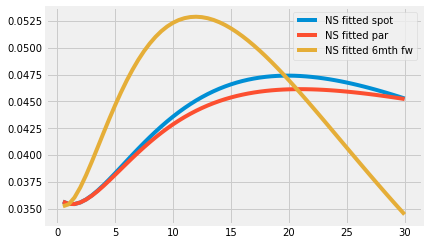

In [13]:
ts = np.linspace(0.5, 30, 60)
fitted_spot = spot_rate(ts, Nelson_Siegel_DF(ts,ns_param)*100)
fitted_par = fitted_par = [par_yield(t_i, lambda t: Nelson_Siegel_DF(t,ns_param)) for t_i in ts]
fitted_fw = [fw_rate(t_i, 0.5, lambda t: Nelson_Siegel_DF(t,ns_param)) for t_i in ts]

plt.plot(ts, fitted_spot, label='NS fitted spot')
plt.plot(ts, fitted_par, label='NS fitted par')
plt.plot(ts, fitted_fw, label='NS fitted 6mth fw')

plt.legend()

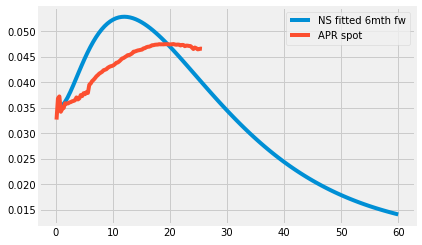

In [14]:
ts = np.linspace(0.5, 60, 120)
fitted_fw = [fw_rate(t_i, 0.5, lambda t: Nelson_Siegel_DF(t,ns_param)) for t_i in ts]
plt.plot(ts, fitted_fw, label='NS fitted 6mth fw')
plt.plot(STRIPS.Mat, STRIPS.Spot, label='APR spot')
plt.legend()

# Svensson

In [15]:
def Svensson_DF(t, params):
    
    b0, b1, b2, b3 = params[0], params[1], params[2], params[3]
    t_1, t_2 = t / params[4], t / params[5]
    r = b0 + b1 * (1 - np.exp(-t_1)) / t_1 + b2 * ((1 - np.exp(-t_1)) / t_1 - np.exp(-t_1)) \
    + b3 * ((1 - np.exp(-t_2)) / t_2 - np.exp(-t_2))
    
    return np.exp(-r * t)

def SV_fitted_err(Mat, Px, params):
    
    err = Px - Svensson_DF(Mat, params) * 100
    w = 1 / Mat
    return w.dot(err ** 2)

In [16]:
sv_output = mp.Queue()
sv_processes = [mp.Process(target=optimizer, name='sv_%d'%i,
                           args=(SV_fitted_err, sv_output, 4, 2)) for i in range(20)]

for p in sv_processes:
    p.start()

for p in sv_processes:
    p.join()

results = [sv_output.get() for p in sv_processes]
sv_param = fetch_min_param(results)

Starting: sv_0
Starting: sv_1
Starting: sv_2
Starting: sv_3
Starting: sv_4
Starting: sv_5
Starting: sv_6
Starting: sv_8
Starting: sv_7
Starting: sv_10
Starting: sv_9
Starting: sv_11
Starting: sv_12
Starting: sv_13
Starting: sv_14
Starting: sv_17
Starting: sv_15
Starting: sv_16
Starting: sv_18
Starting: sv_19
Exiting: sv_12
Exiting: sv_1
Exiting: sv_13
Exiting: sv_14
Exiting: sv_0
Exiting: sv_2
Exiting: sv_16
Exiting: sv_17
Exiting: sv_8
Exiting: sv_19
Exiting: sv_18
Exiting: sv_5
Exiting: sv_11
Exiting: sv_15
Exiting: sv_3
Exiting: sv_6
Exiting: sv_7
Exiting: sv_9
Exiting: sv_4
Exiting: sv_10


In [17]:
print sv_param
SV_fitted_err(STRIPS.Mat, STRIPS.Px, sv_param)

[ 0.02579837  0.00943241 -0.12676828  0.17608622  5.58174369  7.5694163 ]


0.28066094678322606

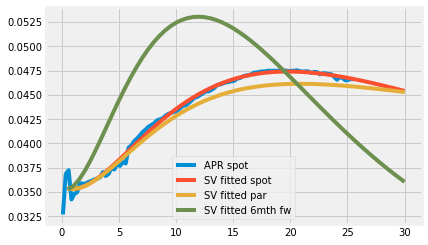

In [18]:
ts = np.linspace(0.5, 30, 60)

fitted_spot = spot_rate(ts, Svensson_DF(ts, sv_param)*100)
fitted_par = [par_yield(t_i, lambda t: Svensson_DF(t, sv_param)) for t_i in ts]
fitted_fw = [fw_rate(t_i, 0.5, lambda t: Svensson_DF(t, sv_param)) for t_i in ts]

plt.plot(STRIPS.Mat, STRIPS.Spot, label='APR spot')
plt.plot(ts, fitted_spot, label='SV fitted spot')
plt.plot(ts, fitted_par, label='SV fitted par')
plt.plot(ts, fitted_fw, label='SV fitted 6mth fw')

plt.legend()

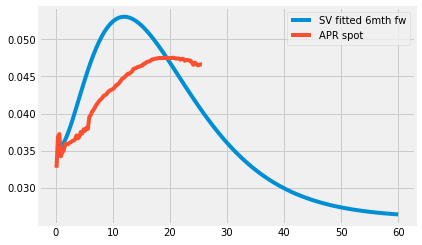

In [19]:
ts = np.linspace(0.5, 60, 120)
fitted_fw = [fw_rate(t_i, 0.5, lambda t: Svensson_DF(t, sv_param)) for t_i in ts]
plt.plot(ts, fitted_fw, label='SV fitted 6mth fw')
plt.plot(STRIPS.Mat, STRIPS.Spot, label='APR spot')
plt.legend()